# Year Season Time Series 

| Northern hemisphere | Southern hemisphere | Start date |	End date|  
|---------------------|---------------------|------------|----------|
| Winter | 	Summer 	  | 1 December |	28 February |
| Spring | 	Autumn 	  | 1 March    |    31 May  |
| Summer |	Winter 	  | 1 June 	   | 31 August  |
| Autumn 	| Spring 	| 1 September 	|30 November   |

https://en.wikipedia.org/wiki/Season

**Steps**

1. Detectar si hubo o no WE por semana
2. Contar NMAX de valores posibles por mes
3. contar NVAL num de valores validos por mes
4. Contar NWE num de we por mes
5. (NWE/NVAL)*NMAX nos da una aproximacion de weekend effect por mes
6. Hacer esto mismo pero por estaciones meteorologicas del ano

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import autocorrelation_plot
import statsmodels.graphics.tsaplots as tsa
from scipy import stats
from scipy.stats import shapiro
import statsmodels.stats.diagnostic as statsd
from scipy.stats import ttest_ind
import matplotlib.ticker as ticker
plt.rcParams["figure.figsize"] = [16.4, 6.8] 

In [161]:
sites = stations = ["CUA","FAC", "MER", "MON", "PED", "SAG","TAH","TLA","UIZ","XAL"]
df = pd.read_csv("sample/sample.csv")
sites = list(df.columns[1:])
l = len(df[sites])

dates = pd.to_datetime(df["date"],format = '%Y-%m-%d')
#df.set_index("date")

In [162]:
df["date"]= dates

df = df.set_index("date")


In [163]:
def arimaPredict(Y,ARMAM,trs, lag, linear, prints = False):
    from statsmodels.tsa.arima_model import ARIMA
    m = linear[0]
    b = linear[1]
    print(ARMAM)
    ar = int(ARMAM[0])
    inte = int(ARMAM[1])
    ma = int(ARMAM[2])
    print("d= ", inte)
    predictions = list()
    linear_predictions = list()
    naive_predictions = list()
    obsrvations = list()
    ub = len(Y)
    lb = int(np.floor(len(Y)*trs))
    X = range(ub+1)
    for i in range(lb, ub+1):
        if prints: print(i)
        model = ARIMA(Y[:i],order=(ar,inte,ma))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0][0]
        predictions.append(yhat)
        if i > (len(Y)-1):
            obsrvations.append(float('NaN'))
        else:
            obsrvations.append(Y[i])
        naive_predictions.append(Y[i-1])
        linear_predictions.append(m*X[i]+b)
    return [predictions, obsrvations, linear_predictions,naive_predictions]

In [164]:
df

,CUA,FAC,MER,MON,PED,SAG,TAH,TLA,UIZ,XAL
date,,,,,,,,,,
1994-01-31,-67.250000,-62.00,-56.25,-42.50,-80.50,-27.250000,-41.333333,-10.50,-62.00,-28.00
1994-02-28,38.333333,-30.25,7.25,14.00,-31.75,-3.333333,16.750000,-21.75,13.50,-5.50
1994-03-31,-18.000000,-39.40,-32.80,-25.20,-28.20,-68.400000,-17.800000,-17.40,-16.80,-20.40
1994-04-30,-48.000000,-70.75,-10.75,-10.00,-48.75,1.500000,16.750000,-25.75,-13.75,-2.50
1994-05-31,-63.000000,-34.25,-45.25,-30.25,-40.25,-17.250000,-54.750000,-24.75,-37.00,-41.00
...,...,...,...,...,...,...,...,...,...,...
1999-07-31,-6.750000,-11.75,-34.00,-15.50,-26.00,-4.250000,-2.750000,-16.50,-18.50,-7.25
1999-08-31,-13.500000,-0.25,2.50,-7.75,-11.50,-2.750000,-26.750000,10.50,4.75,-2.25
1999-09-30,13.600000,10.80,11.20,-6.60,20.40,3.000000,7.600000,10.40,12.20,16.00


In [153]:
data

date
1994-01-31   -67.250000
1994-02-28    38.333333
1994-03-31   -18.000000
1994-04-30   -48.000000
1994-05-31   -63.000000
                ...    
1999-07-31    -6.750000
1999-08-31   -13.500000
1999-09-30    13.600000
1999-10-31    34.500000
1999-11-30   -55.333333
Name: CUA, Length: 71, dtype: float64

In [169]:
#matrix = np.array(df[sites])
#matrix

def prediction(df,tr,columns):
    dfObj = pd.DataFrame( columns = ['#' , 'Name', 'Range' , 'size', "ARIMA", "MAE_ARIMA", "MAE_LINE", "MAE_NAIVE","GAUSS_ARIMA", "GAUSS_LINE", "GAUSS_NAIVE","ttest"]) 
    prefix = "o3_"
    extension = "_y.csv"
    stations = columns
    ARIMAModels = [(0,0,0),(8,0,0),(8,0,0),(0,0,0),(10,0,0),(3,0,0),(2,0,0),(8,0,0),(0,0,0),(8,0,0)]
    
    ARIMAModels = [(0,0,0),(8,0,0),(8,0,0),(3,1,0),(15,0,0),(3,0,0),(0,0,0),(8,0,0),(10,0,0),(3,0,0)]
    ix_end = range(len(stations))
    
    for ix in ix_end:
        s = stations[ix]
        print(s)
       
        n_test = 2
        fn = (prefix + s + extension)
        data = df[s]
        
        
        i00 = data.index[0]
        i01 = data.index[-1]
        
   #     plt.plot(data)
   #     plt.show()
        Y = np.array(data)
        print(Y)
        print(len(Y))
        X = range(len(Y))
        x_training = X[0:int(np.floor(len(X)*tr))]
        y_training = Y[0:int(np.floor(len(Y)*tr))]

        x_validation = X[int(np.floor(len(X)*tr)):len(X)]
        y_validation = Y[int(np.floor(len(Y)*tr)):len(Y)]

        print("Computing with Theil-Sen Slopes")
        r = stats.theilslopes(y_training, x_training, 0.99)
        slope = r[0]
        intercept = r[1]
    
        print("slope: " + str(slope))
        print("inter: " + str(intercept))

        trend = np.array(X)*slope+intercept
    
        ARIMAM = ARIMAModels[ix]
        #[predictions, obsrvations, linear_predictions,naive_predictions]
        
        print("data")
        print(np.array(data[1]))
        forecasts = arimaPredict(Y,ARIMAM,tr,1,[slope,intercept]) 
    
    
    
        print("arimamodel:",ARIMAM)
        maearima = np.mean(np.abs(np.array(forecasts[1])-np.array(forecasts[0])))
        maeline = np.mean(np.abs(np.array(forecasts[1])-np.array(forecasts[2])))
        print(maearima, " ",maeline)
    
        fig, axs = plt.subplots()

    
   #     xdate = data[int(np.floor(len(X)*tr))::][0]
        xdate = data.index[int(np.floor(len(X)*tr))::][0]

        predictions_a = np.transpose(forecasts[0])
        predictions_c = np.transpose(forecasts[2])
        predictions_d = np.transpose(forecasts[3])
        observations  = np.transpose(forecasts[1])
    
        methods = ["ARIMA","LINE","NAIVE"]
    
    
        predictions = [predictions_a,predictions_c,predictions_d]
    
        #we evaluate the residuals of all the test set by exception the last two years, 
        #where the las year we really do know and the penultimate year is used to validate the prediction
        residuals = list(map(lambda x: x[:-n_test]-observations[:-n_test],predictions))
        MAES =  np.mean(np.abs(residuals),axis=1)
        sw_normality_test = list(map(lambda x: shapiro(x), residuals))
        val_test_set = list(map(lambda x: (x[-n_test:]),predictions))
    
        i_min = np.argmin(MAES)
        best_prediction = val_test_set[i_min]
    
   
        p = 0.05
        # plt.plot(np.array(residuals[0:1][:]).T)
        lbt = lambda x: statsd.acorr_ljungbox(x,lags=np.min([4,10,len(residuals[0][:])-1]),boxpierce=False)[1]
        lbxts = list(map(lambda x: lbt(x),np.array(residuals[:][:]))) 
        print(lbxts)
        print(map(lambda x: (x>0.05)*1, lbxts))
    
    
    

        y01 = predictions_a-observations
        y02 = predictions_c-observations
        y03 = predictions_d-observations
    
    
        arimaMAE = np.mean(np.abs(y01))
        lineMAE  = np.mean(np.abs(y02))
        naiveMAE = np.mean(np.abs(y03))
    
 
    

        stat_1, p_1 = shapiro(y01)
        stat_2, p_2 = shapiro(y02)
        stat_3, p_3 = shapiro(y03)
    
    
        print('ARIMA Statistics=%.3f, p=%.3f' % sw_normality_test[0] )
        print('LINE_ Statistics=%.3f, p=%.3f'  % sw_normality_test[1])
        print('NAIVE Statistics=%.3f, p=%.3f'  % sw_normality_test[2])
        # interpret
        alpha = 0.05
    
        reject_sw = list(map(lambda x: x[1] > alpha, sw_normality_test))
    
        # no rechazar h0 si p > alpha=0.05
        garima = p_1 > alpha
        gline =  p_2 > alpha
        gnaive = p_3 > alpha
    
        #   f_best = MAES_arg_sort[0]
        #   s_best = MAES_arg_sort[1]
        #    print(str(methods[f_best])+' vs '+str(methods[s_best]))
        #    if (reject_sw[f_best]) & (reject_sw[s_best]):
        #        print('Samples looks Gaussian (fail to reject H0)')
        #    else:
        #        print('Sample does not look Gaussian (reject H0)')
        
        print("ARIMA: "+str(p_1)+" "+str(garima))
        print("Line:" + str(p_2)+" "+str(gline))  
    
        ttest,pval = ttest_ind(y01,y02)
        print("If p-value is below alpha, we reject the null hypotesis that states that mean_a = mean_b")
        print("p-value",pval)
        if pval < alpha:
            print("we reject null hypothesis H0")
        else:
            print("we accept null hypothesis H0")
        
    #'#' , 'Name', 'Range' , 'size', "ARIMA", "MAE_ARIMA", "MAE_LINE", "MAE_NAIVE","best_prediction","best_model","GAUSS_ARIMA", "GAUSS_LINE", "GAUSS_NAIVE"    
        dfObj = dfObj.append({
            '#': s , 
            'Name': s, 
            'Range':  str(i00).replace('-','/') + "-" + str(i01).replace('-','/') , 
            'size': len(data), 
            "ARIMA": ARIMAM, 
            "MAE_ARIMA": np.mean(np.abs(residuals),axis=1)[0], 
            "MAE_LINE": np.mean(np.abs(residuals),axis=1)[1], 
            "MAE_NAIVE": np.mean(np.abs(residuals),axis=1)[2],
            "best_model": str(int(i_min+1)),
            "best_prediction": best_prediction,

        
            "mean_ARIMA": np.mean(residuals,axis=1)[0],
            "mean_LINE":  np.mean(residuals,axis=1)[1],
            "mean_NAIVE": np.mean(residuals,axis=1)[2],
            "std_ARIMA":  np.std(residuals,axis=1)[0],
            "std_LINE":   np.std(residuals,axis=1)[1],
            "std_NAIVE":  np.std(residuals,axis=1)[2],
            "bpval_ARIMA": (lbxts[0]>0.05)*1,
            "bpval_LINE": (lbxts[1]>0.05)*1,
            "bpval_NAIVE": (lbxts[2]>0.05)*1,
            "pval_ARIMA": (lbxts[0]),
            "pval_LINE": (lbxts[1]),
            "pval_NAIVE": lbxts[2],
        
        
            "GAUSS_ARIMA" : garima, 
            "GAUSS_LINE": gline, 
            "GAUSS_NAIVE": gnaive,
            "ttest $\mu_1=\mu_0$":  "not equal" if pval < alpha else "equal"
            } , ignore_index=True)
    
        axs.set_title(s)
  #      xdate_year= list(map(lambda i: xdate.iloc[i][-4:], range(len(xdate))))
  #      xdate_year.append('2019')
        xdate_year = range(len(forecasts[0]))
        axs.plot(xdate_year,np.array(forecasts[0]),'--',color="blue", linewidth=1.5)
        axs.plot(xdate_year,np.array(forecasts[1]),'-',color="black", linewidth=0.5)
        axs.plot(xdate_year,np.array(forecasts[2]),':',color="red", linewidth=1.5)
        axs.plot(xdate_year,np.array(forecasts[3]),'o',color="gray", linewidth=1.5)
    
        axs.xaxis.set_major_locator(ticker.FixedLocator([0,2,4,6,8,10]))
    
        axs.set_ylabel("$\mathit{OWD^{sun}}$")
        axs.set_xlabel(" ")
    
        ts_names = ["ARIMA","Observed","Linear","Naive"]
        plt.legend(ts_names)
        plt.show()
    
        fsname = "fig"+str(ix)+".pdf" 
        print(fsname)
        fig.savefig(fsname,dpi=300)
    
        #savecsv
    
    #    np.shape(np.transpose(forecasts)) #,np.transpose(xdate_year)
        A = np.append(np.transpose(np.array([xdate_year])),np.transpose(forecasts), axis = 1) 
        Adf = pd.DataFrame(A, columns=["year","ARIMA","Observed","Linear","Naive"])
        Adf.to_csv(s+".csv")
    dfObj.to_csv("table70.csv")
        
        
        
        

        
    
    
    
    


    
    

CUA
[-67.25        38.33333333 -18.         -48.         -63.
 -23.8        -14.          -0.2         -7.5         26.75
   3.6        -47.25        22.75        -7.         -25.8
  22.         -12.4          9.25        -0.75       -29.25
 -32.25       -16.75         8.4        -35.5         14.6
 -65.25       -55.25       -33.5        -30.8        -36.5
 -31.8         11.         -33.5          4.2        -41.5
  18.75         2.6         42.5         -3.75       -41.4
 -15.25        18.25       -20.8        -66.         -32.25
   4.           0.5          9.8         -3.5         38.25
  15.66666667  23.6        -11.5        -44.75       -21.6
 -40.25       -15.8          7.          -9.         -29.6
 -83.25       -42.         -52.8        -15.           1.25
 -17.6         -6.75       -13.5         13.6         34.5
 -55.33333333]
71
Computing with Theil-Sen Slopes
slope: 0.10208333333333333
inter: -16.45
data
38.333333333333336
(0, 0, 0)
d=  0
arimamodel: (0, 0, 0)
nan   nan
[ar

/Users/rodrigo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


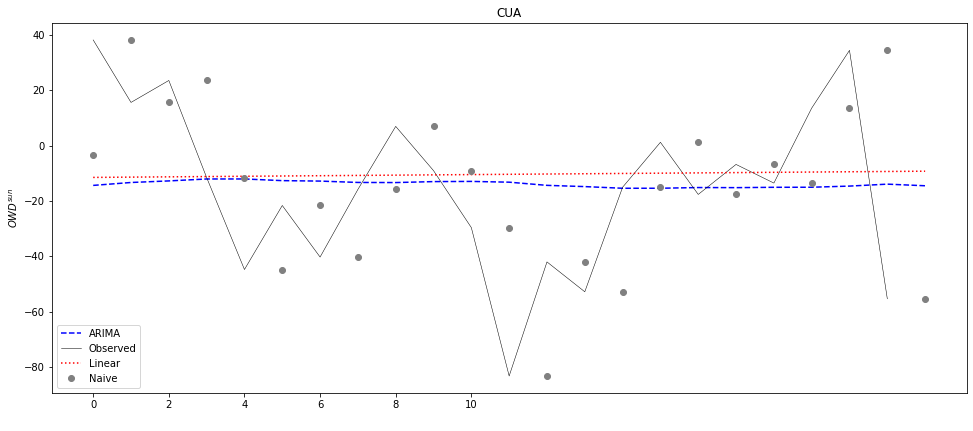

fig0.pdf
FAC
[ -62.          -30.25        -39.4         -70.75        -34.25
   24.          -47.5          24.2          -9.           22.
  -20.          -30.5          57.5         -19.           -5.8
  -23.25         -0.8         -18.          -27.66666667  -21.
  -33.75         15.5         -54.2         -23.5         -40.
  -26.75        -48.75        -45.25        -58.          -48.
  -26.4          46.75        -23.5         -16.6          -4.25
  -15.25          8.2          47.75         53.75       -106.8
  -16.           54.25         -4.8         -20.25         39.75
  -22.4          27.5          21.           27.           -6.5
   -5.           36.6          -1.5         -30.5          11.4
  -19.5          -0.8          20.          -14.75        -25.2
  -91.75        -98.25        -68.6          -1.25         -1.75
   -1.4         -11.75         -0.25         10.8          46.25
  -59.        ]
71
Computing with Theil-Sen Slopes
slope: 0.7341666666666665
inter: -37.62

/Users/rodrigo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


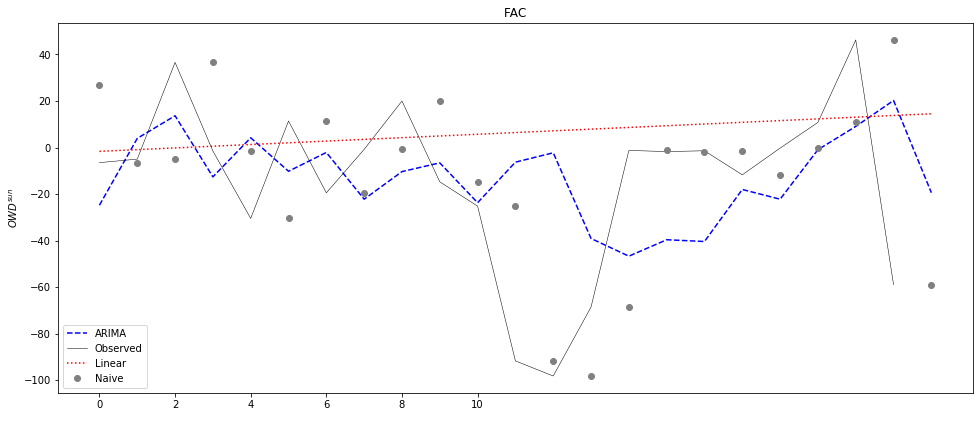

fig1.pdf
MER
[-56.25         7.25       -32.8        -10.75       -45.25
 -32.6        -15.25       -13.         -19.          26.25
  35.4        -18.5         30.          -9.5        -28.4
  20.75         7.8        -54.25        26.5        -12.8
  -6.5        -26.75        36.4        -49.          19.8
 -35.5        -20.5        -17.75       -46.8        -41.25
 -40.          50.25       -22.25        -4.8        -16.5
  -0.5         26.2         50.75        -5.75       -80.
  30.75        49.25        -9.2        -25.          20.25
   1.6        -11.25        37.          -3.5        -16.
  13.5         20.6        -24.75       -24.5         -0.2
 -11.           8.8         14.5        -14.         -16.4
 -51.         -22.75       -73.         -35.         -36.66666667
 -24.         -34.           2.5         11.2         49.5
 -32.        ]
71
Computing with Theil-Sen Slopes
slope: 0.5089978448275861
inter: -22.96594827586207
data
7.25
(8, 0, 0)
d=  0
arimamodel: (8, 0, 0)
na

/Users/rodrigo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


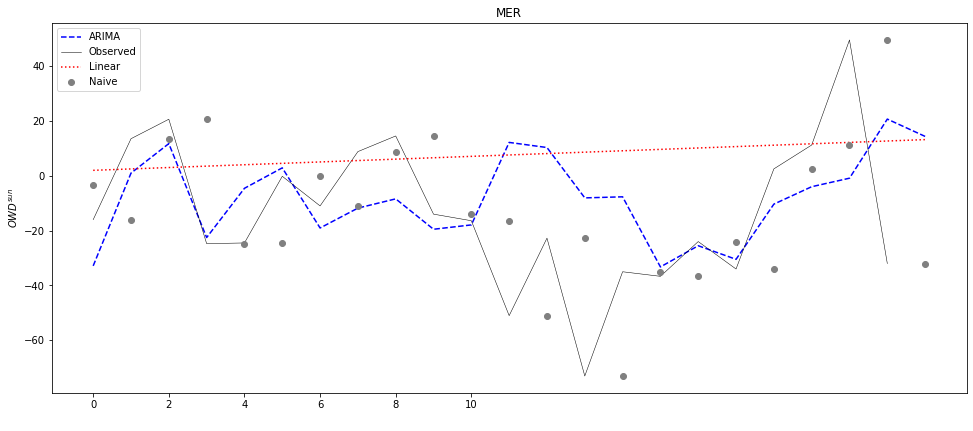

fig2.pdf
MON
[-42.5         14.         -25.2        -10.         -30.25
  -1.2         10.75         6.4        -35.          29.5
   3.         -33.          42.75        15.           8.8
  13.5         21.4        -15.5         16.5          6.
   7.66666667  12.5         18.2        -24.5          4.8
  -9.25       -27.75       -18.         -11.8        -16.5
  -6.4         49.75         6.75        -2.8         24.75
 -15.          13.8         13.          18.75       -31.
 -15.          13.75        14.8         21.          37.5
   3.4         25.25        33.8        -16.         -22.75
   1.66666667  28.6         16.75        -3.          -2.6
 -15.75        23.2          5.5         -4.5          2.6
   8.75       -47.25        -8.8          0.75       -16.
 -18.6        -15.5         -7.75        -6.6         26.25
 -19.25      ]
71
Computing with Theil-Sen Slopes
slope: 0.39919354838709675
inter: -3.1806451612903217
data
14.0
(3, 0, 0)
d=  0
arimamodel: (3, 0, 0)
nan   na

/Users/rodrigo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


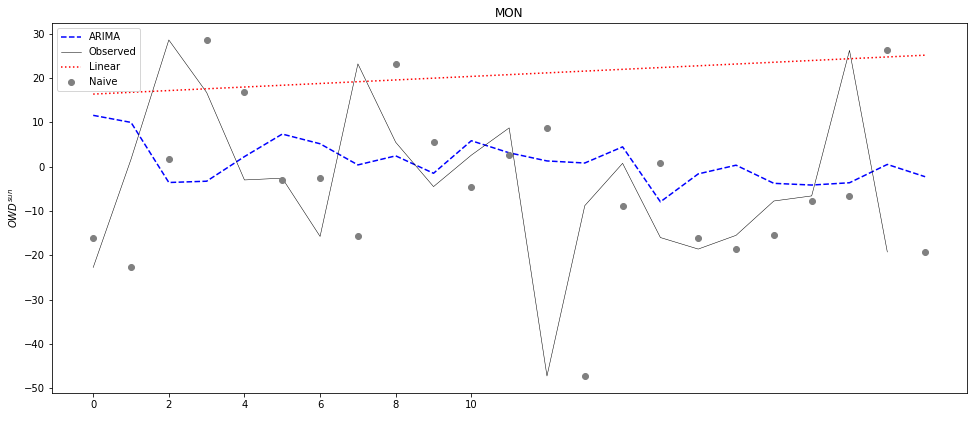

fig3.pdf
PED
[-80.5  -31.75 -28.2  -48.75 -40.25 -81.   -33.   -45.8  -67.5   14.
  11.   -48.25  21.     8.25 -18.6    4.   -39.4  -62.    29.5  -39.
 -16.25 -46.75  14.6  -43.25  21.6  -37.75 -28.   -50.25 -49.8  -14.25
 -49.4   -5.25 -57.5   -5.2  -23.25   4.     2.6   40.5   -9.25 -92.
   9.75   3.25  -9.4  -54.5   35.    20.   -21.75 -13.2    7.5   18.
 -10.25  39.2    8.   -63.   -41.8  -22.75 -33.2   15.25 -12.25 -32.8
 -97.5  -84.   -57.   -44.   -10.5  -37.   -26.   -11.5   20.4   54.
 -59.25]
71
Computing with Theil-Sen Slopes
slope: 0.8155034324942791
inter: -41.3220823798627
data
-31.75
(15, 0, 0)
d=  0


/Users/rodrigo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/rodrigo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/rodrigo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rodrigo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1541: RuntimeWarning: invalid value encountered in sqrt
  fcasterr = np.sqrt(sigma2 * np.cumsum(ma_rep ** 2))
/Users/rodrigo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params a

arimamodel: (15, 0, 0)
nan   nan
[array([0.15726394, 0.33958502, 0.26409933, 0.13407068]), array([0.01282914, 0.03131732, 0.07079382, 0.09270241]), array([0.75415198, 0.7895895 , 0.9066702 , 0.66051457])]
ARIMA Statistics=0.948, p=0.316
LINE_ Statistics=0.978, p=0.889
NAIVE Statistics=0.925, p=0.109
ARIMA: 1.0 True
Line:1.0 True
If p-value is below alpha, we reject the null hypotesis that states that mean_a = mean_b
p-value nan
we accept null hypothesis H0


/Users/rodrigo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


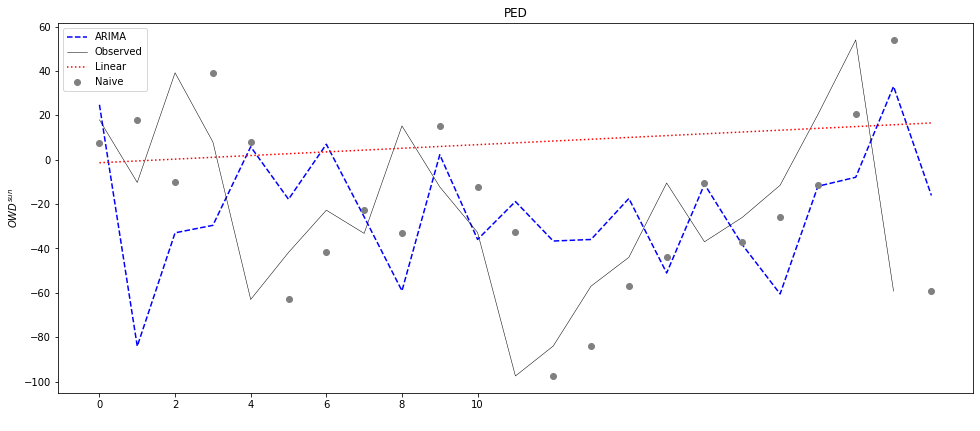

fig4.pdf
SAG
[-27.25        -3.33333333 -68.4          1.5        -17.25
   2.2         25.5          4.          -7.25        18.
  12.6        -35.25        52.75        13.75       -29.4
  15.          16.         -25.75        -4.25        -0.8
  13.25        12.          17.8        -42.           8.2
  10.75       -43.25       -27.         -21.8        -36.25
 -19.2         46.75        -5.           3.8         20.75
   5.25         2.          17.5         19.25       -27.
  17.          15.75         5.8         -2.5         27.
  -3.          22.25        38.4        -15.5        -19.
  13.5         26.8        -28.5        -28.          -5.6
 -25.5         13.2         12.          -1.25        -2.6
 -37.25       -65.25       -17.6        -21.75       -19.25
 -22.2         -4.25        -2.75         3.          18.25
 -33.5       ]
71
Computing with Theil-Sen Slopes
slope: 0.3670454545454545
inter: -5.009090909090909
data
-3.333333333333333
(3, 0, 0)
d=  0
arimamodel: (3, 0,

/Users/rodrigo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


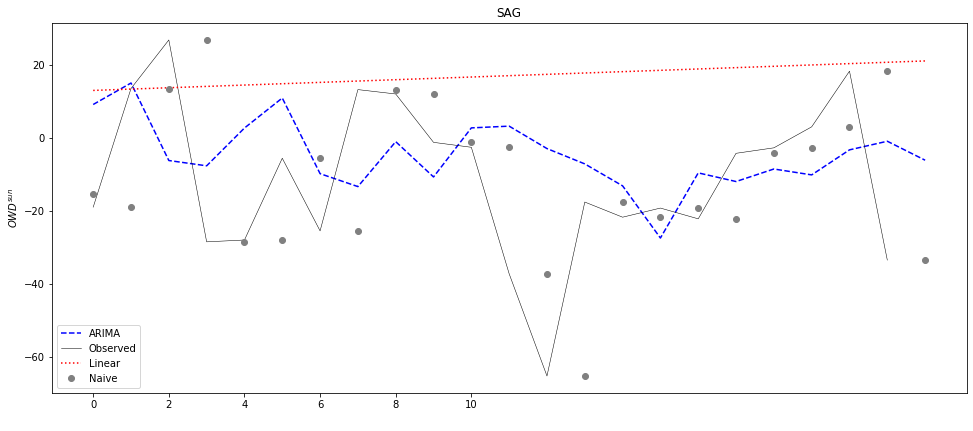

fig5.pdf
TAH
[-41.33333333  16.75       -17.8         16.75       -54.75
 -21.          -3.75       -24.6        -28.75        23.5
  18.6         10.5         44.           8.5         -8.6
  36.75       -20.2         19.25        11.5        -15.8
  42.5        -82.          -2.6        -31.          38.
 -22.75         7.         -14.25       -18.2        -35.5
 -28.         -10.75       -11.75       -11.8         51.5
  31.          17.6         44.5         -5.25       -34.4
  41.          -4.25        45.6        -38.          18.5
 -15.6        -25.25        21.8         28.          25.25
   1.          20.2         -0.25       -28.         -27.4
 -14.75         2.4        -25.25         0.75       -15.4
  10.          -6.         -34.6         -2.5         -2.25
 -18.4         -2.75       -26.75         7.6         14.
 -11.5       ]
71
Computing with Theil-Sen Slopes
slope: 0.29661172161172167
inter: -11.36868131868132
data
16.75
(0, 0, 0)
d=  0
arimamodel: (0, 0, 0)
nan   na

/Users/rodrigo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


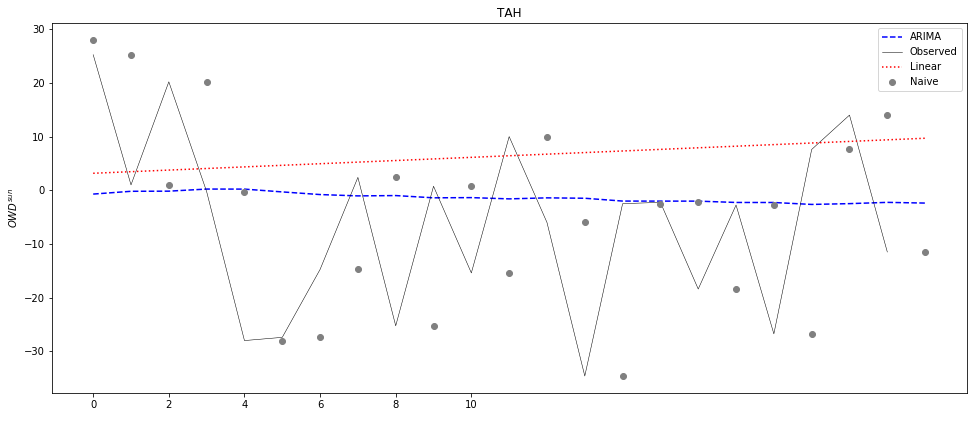

fig6.pdf
TLA
[-10.5  -21.75 -17.4  -25.75 -24.75  18.4  -17.5  -20.4   -8.    46.75
 -15.   -40.75  50.75 -21.    -1.   -34.75  11.8  -18.    15.5   -8.
 -37.25  26.25 -39.4   -9.25 -61.    -8.   -39.5  -41.25 -50.2  -24.
 -22.2   52.25 -25.75 -16.    34.5  -15.75  10.8   23.    18.75 -73.
   4.25  64.25   2.4   10.25  39.75 -26.4   29.    34.6  -13.5  -14.75
  -1.    36.6  -23.   -39.75  20.   -24.    13.2   15.    -9.25 -36.6
 -62.5  -83.25 -37.   -25.    -3.5    6.6  -16.5   10.5   10.4   31.5
 -45.  ]
71
Computing with Theil-Sen Slopes
slope: 0.5272058823529412
inter: -26.152941176470588
data
-21.75
(8, 0, 0)
d=  0
arimamodel: (8, 0, 0)
nan   nan
[array([0.05407532, 0.1456162 , 0.17218219, 0.02389277]), array([0.03227405, 0.06746139, 0.14462153, 0.13529605]), array([0.20791139, 0.39706141, 0.4701117 , 0.16837136])]
ARIMA Statistics=0.863, p=0.007
LINE_ Statistics=0.970, p=0.738
NAIVE Statistics=0.982, p=0.945
ARIMA: 1.0 True
Line:1.0 True
If p-value is below alpha, we reject the nu

/Users/rodrigo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


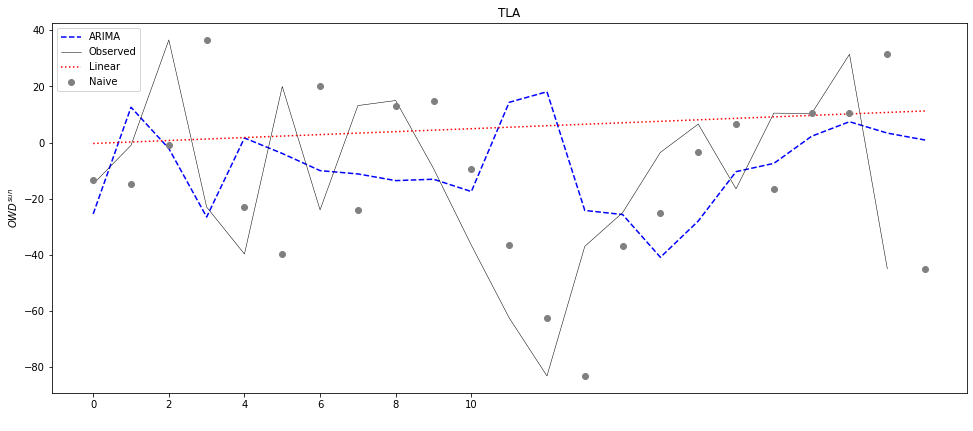

fig7.pdf
UIZ
[-62.    13.5  -16.8  -13.75 -37.   -37.6    1.25  -7.6  -65.5   16.
  30.6  -25.     9.    18.75  -8.2   31.25  -2.4  -30.75  12.75  -7.8
  29.   -56.5   -2.4  -45.75   9.4   -7.25  12.5  -20.   -19.8  -39.25
  -9.4   38.25 -15.5   11.6   -9.5   -3.    18.8   44.   -37.   -64.
  39.75  25.25  27.2  -23.75  58.25  -4.2  -18.     8.8   38.75   3.5
  16.75  45.8   -8.5  -33.75  -0.4  -15.5    0.4    8.75   1.25 -20.
 -25.75 -22.   -47.6   -4.25  -7.   -21.8  -18.5    4.75  12.2   29.
 -17.25]
71
Computing with Theil-Sen Slopes
slope: 0.604375
inter: -18.705
data
13.5
(10, 0, 0)
d=  0
arimamodel: (10, 0, 0)
nan   nan
[array([0.02147828, 0.0682009 , 0.09222138, 0.05707449]), array([0.04025166, 0.11462267, 0.22767106, 0.33598667]), array([0.29449966, 0.12709954, 0.08344349, 0.1537456 ])]
ARIMA Statistics=0.969, p=0.720
LINE_ Statistics=0.973, p=0.796
NAIVE Statistics=0.990, p=0.998
ARIMA: 1.0 True
Line:1.0 True
If p-value is below alpha, we reject the null hypotesis that states

/Users/rodrigo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


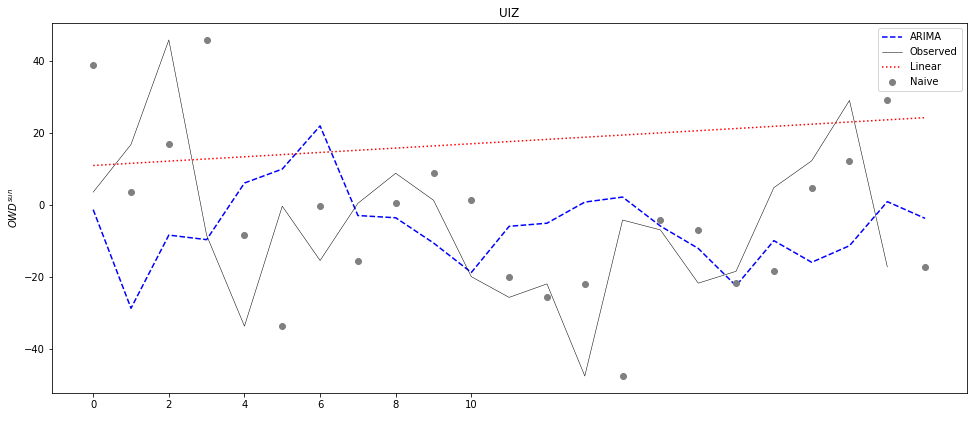

fig8.pdf
XAL
[-28.    -5.5  -20.4   -2.5  -41.     0.2  -10.25  11.   -29.5   30.5
   4.2  -51.75  39.    30.25   1.2   -4.75  52.4  -17.25  16.     1.
   7.25  23.    34.   -43.75  13.2   14.5  -30.75 -17.5  -34.4   -8.25
   2.8   59.25  -4.75   3.2   24.    -4.25   4.    27.5   37.25 -45.4
  41.    53.    12.4   14.    32.25  16.4    9.5   42.4   -4.75 -11.25
  21.    23.   -16.75 -16.25  -3.6  -20.    34.    14.    -5.    -6.4
 -38.   -51.   -30.   -28.5  -12.    -4.2   -7.25  -2.25  16.    35.25
 -25.25]
71
Computing with Theil-Sen Slopes
slope: 0.6854385964912282
inter: -12.450526315789475
data
-5.5
(3, 0, 0)
d=  0
arimamodel: (3, 0, 0)
nan   nan
[array([0.01215011, 0.04044231, 0.05499591, 0.02647348]), array([0.01117141, 0.02599992, 0.0616917 , 0.06435648]), array([0.49926471, 0.59189363, 0.53692235, 0.10547362])]
ARIMA Statistics=0.972, p=0.773
LINE_ Statistics=0.959, p=0.492
NAIVE Statistics=0.984, p=0.968
ARIMA: 1.0 True
Line:1.0 True
If p-value is below alpha, we reject the n

/Users/rodrigo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


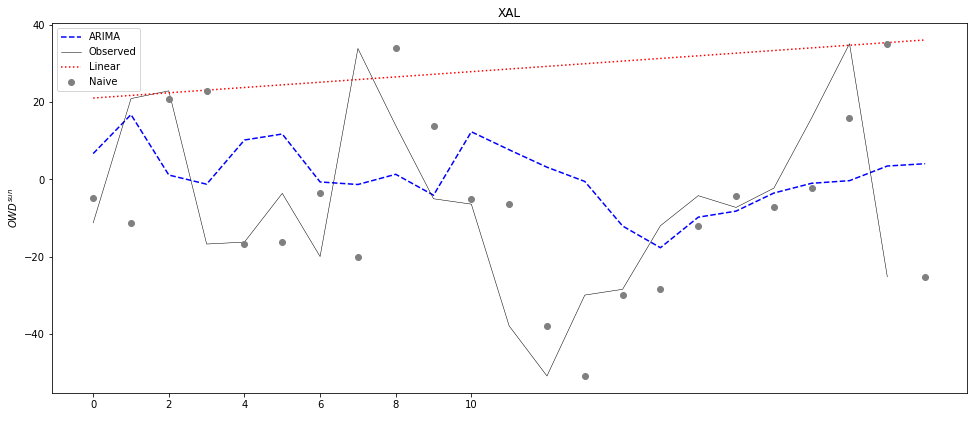

fig9.pdf


In [170]:
prediction(df,0.7,sites)

In [6]:

bin_df = df[sites]>0
bin_df["date"] = pd.to_datetime(df["date"])
bin_df.set_index("date")

#bin_df

#bin_df
#bin_df.index

KeyError: 'date'

In [11]:
bin_df.resample("M")

In [20]:
y = df[s][:int(.85*l)]
61/len(y)

0.8591549295774648

CUA


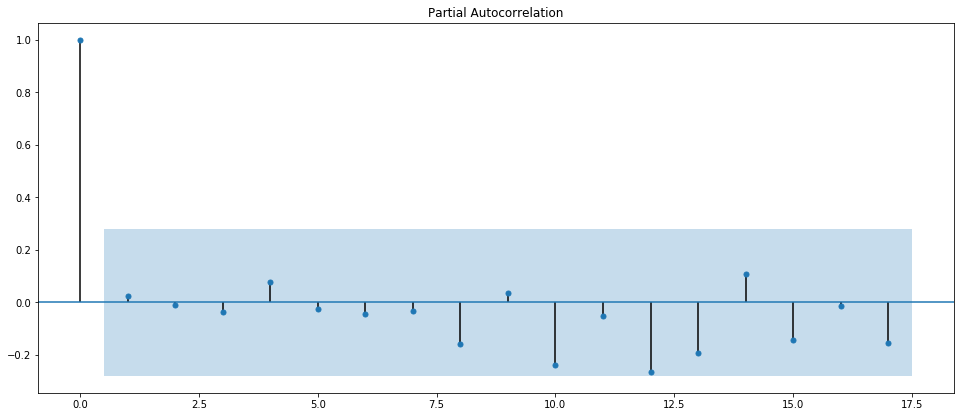

FAC


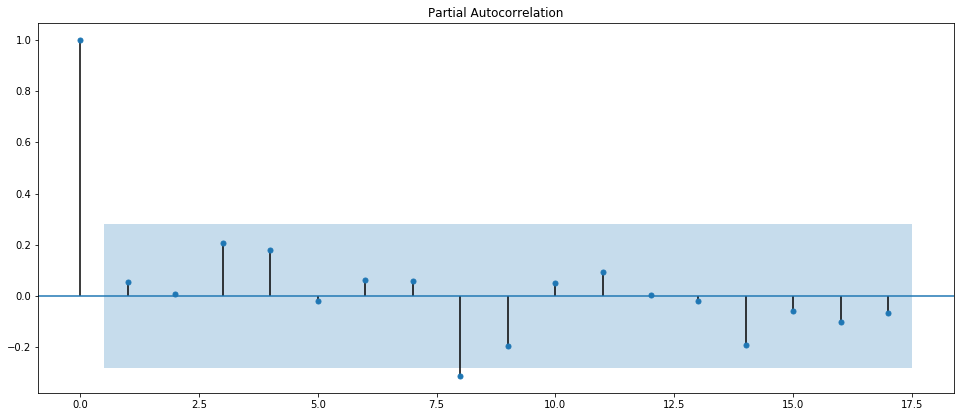

MER


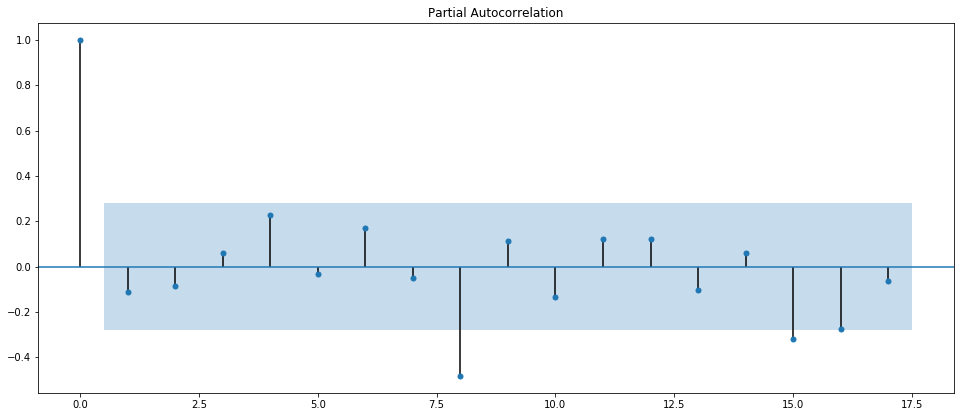

MON


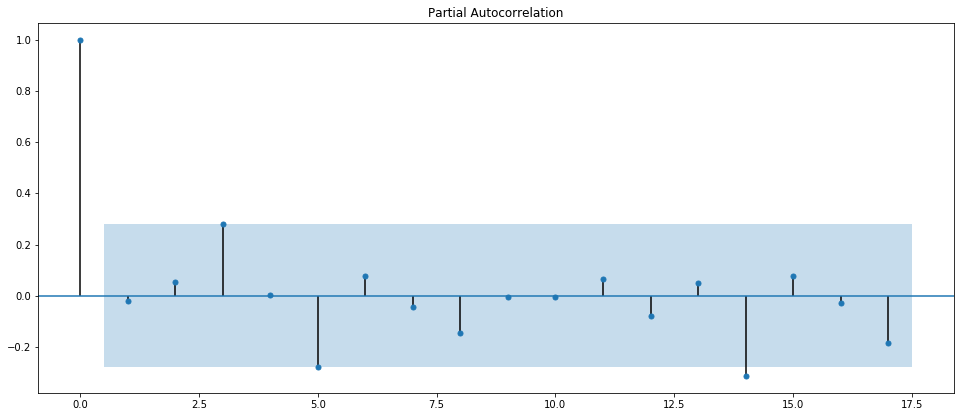

PED


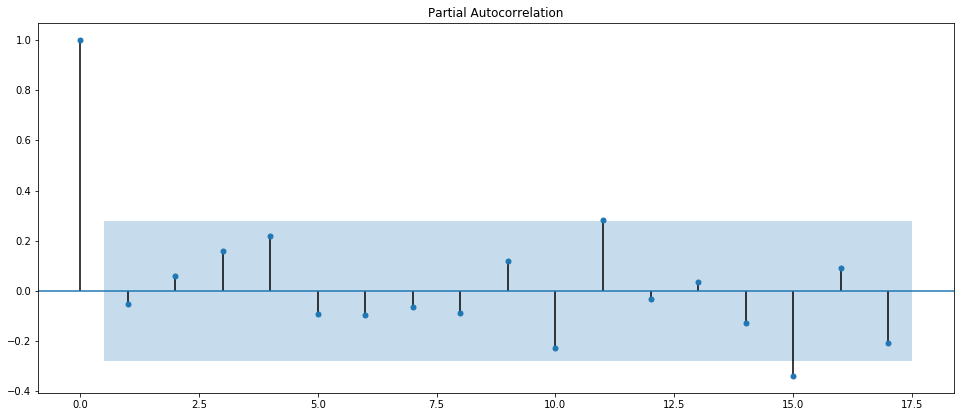

SAG


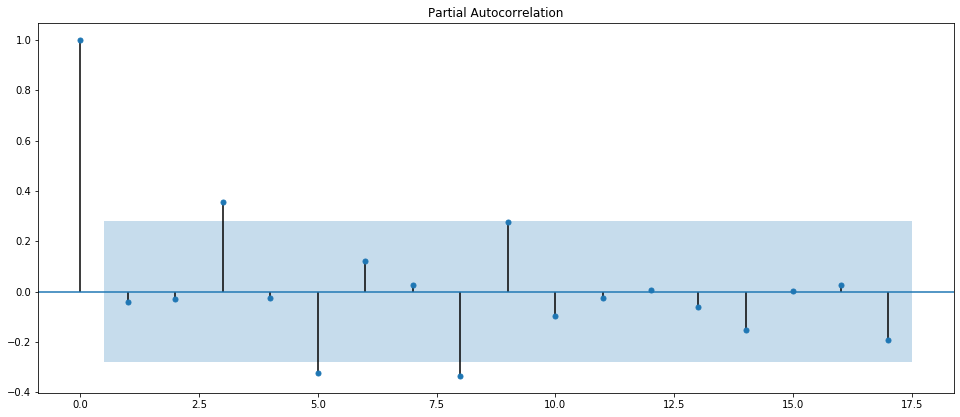

TAH


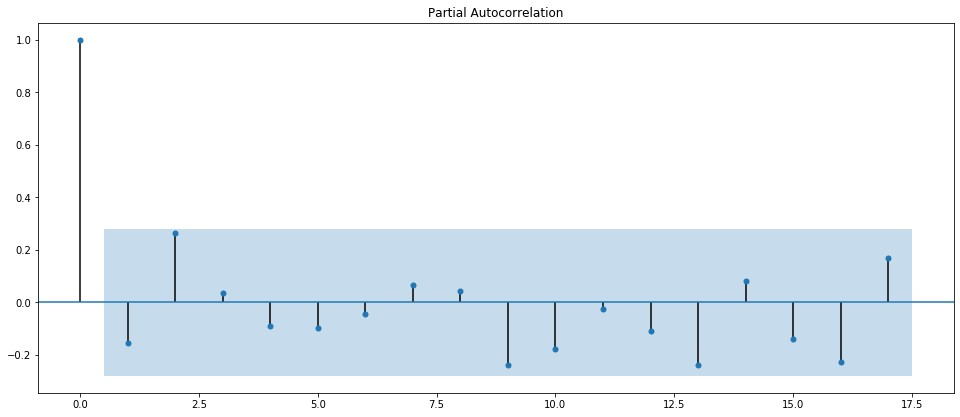

TLA


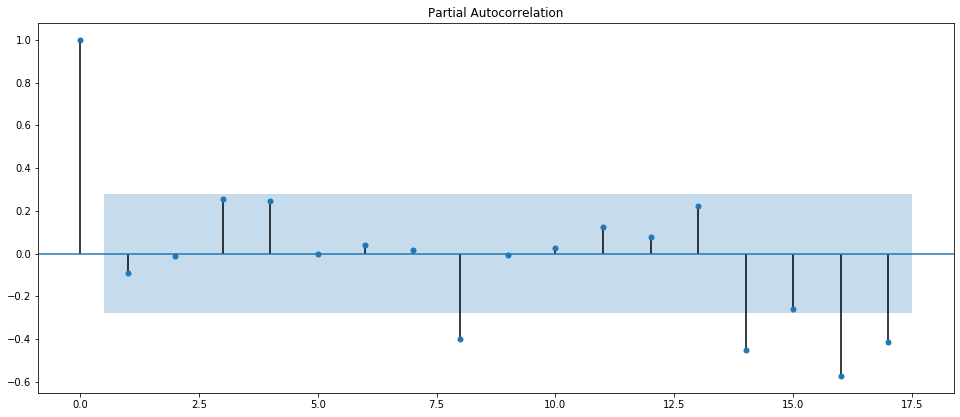

UIZ


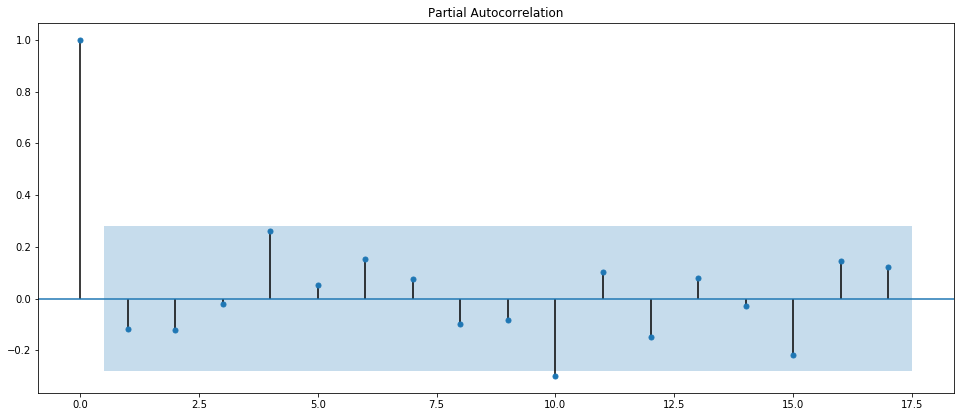

XAL


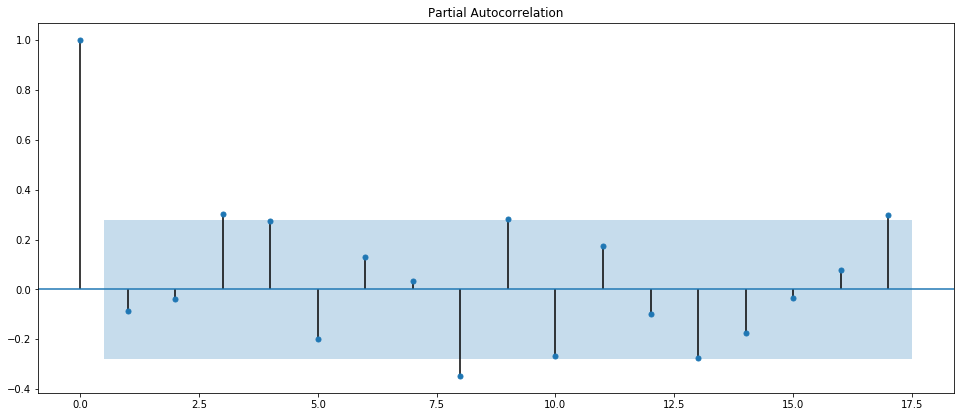

In [167]:
for s in sites:
    print(s)
    y = df[s][:int(0.7*l)]
    #df["group"]=np.arange(len(df))//6
    #y = df.groupby("group").sum()[s]
   
    
    
 #   autocorrelation_plot(y)
    tsa.plot_pacf(y)
 #   plt.hist(y)
    plt.show()

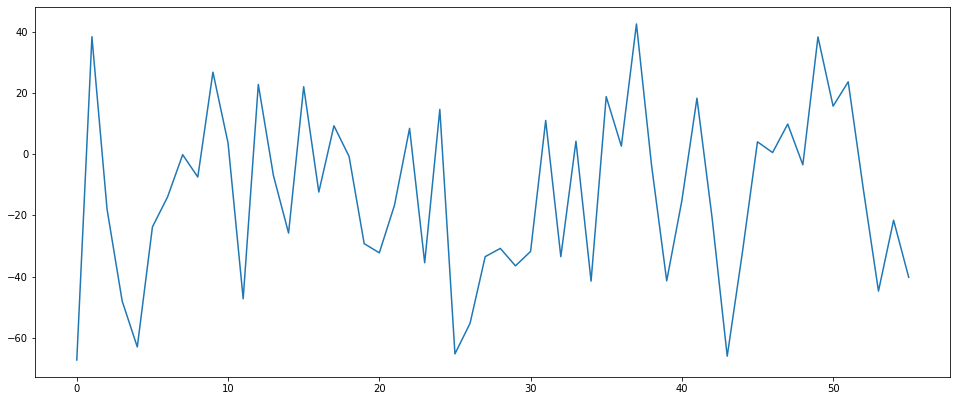

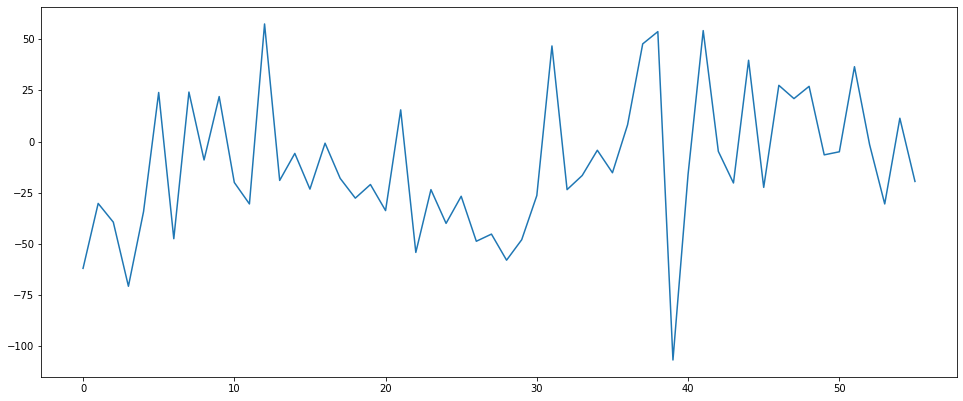

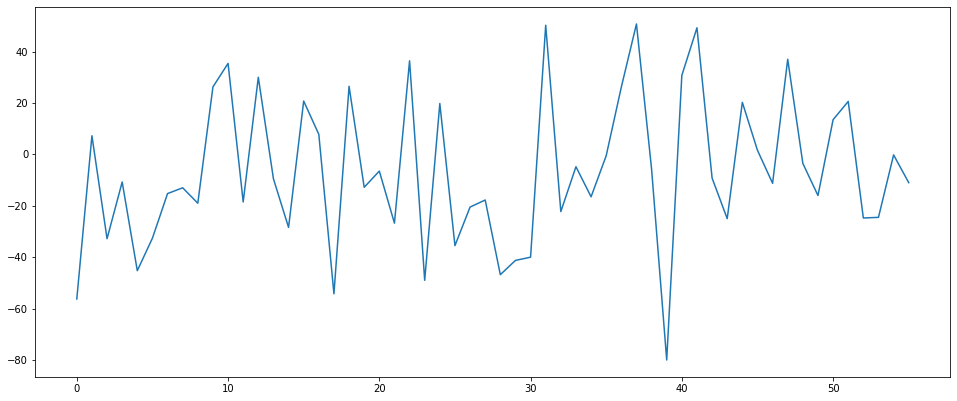

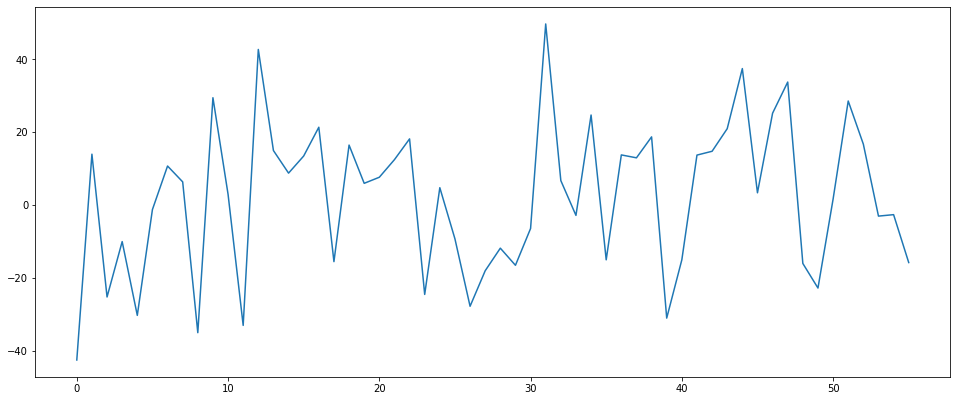

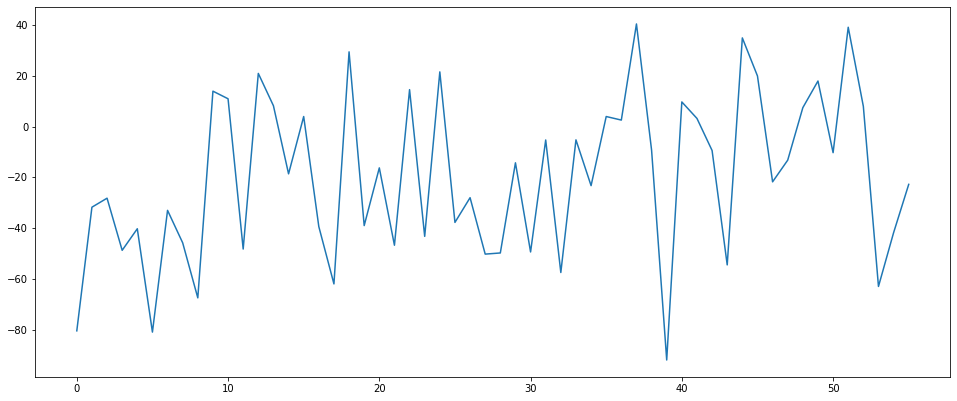

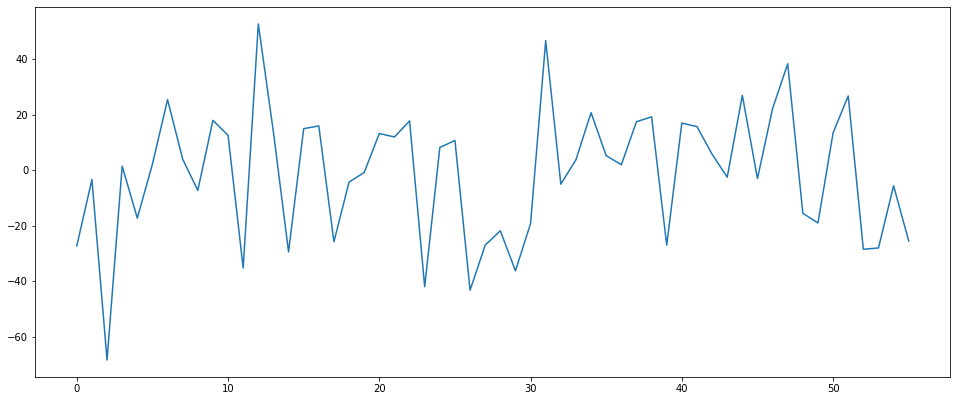

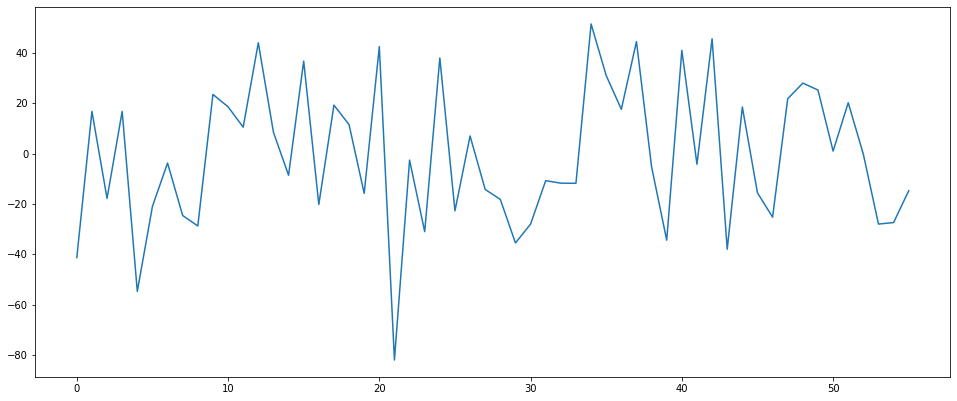

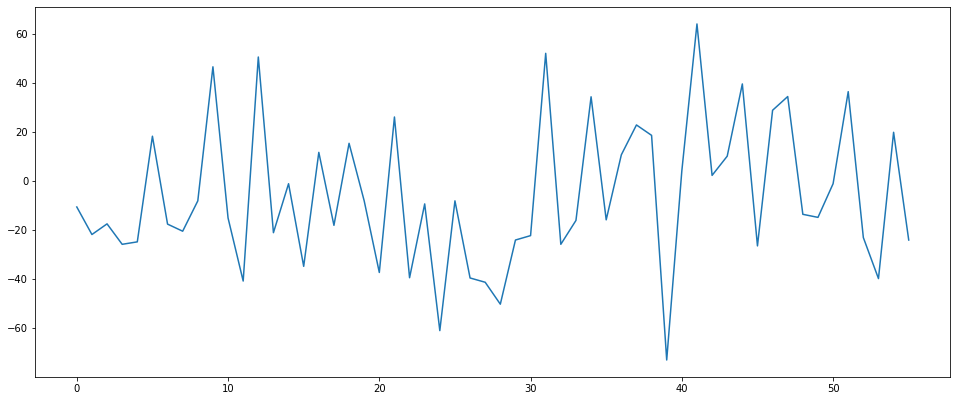

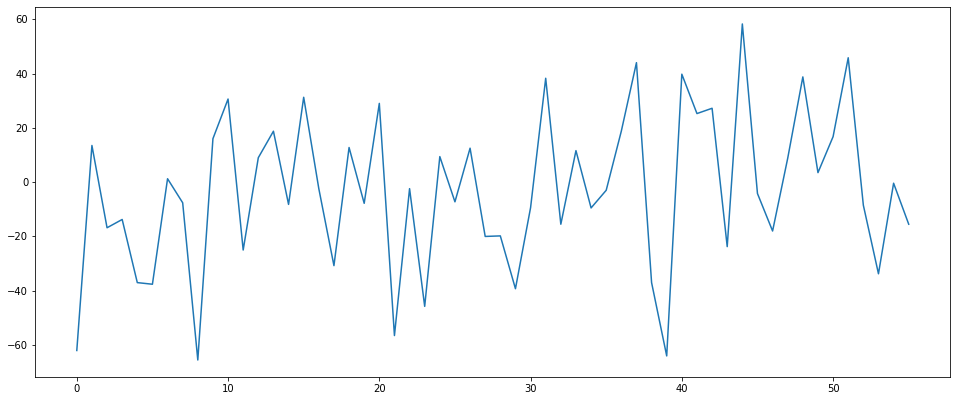

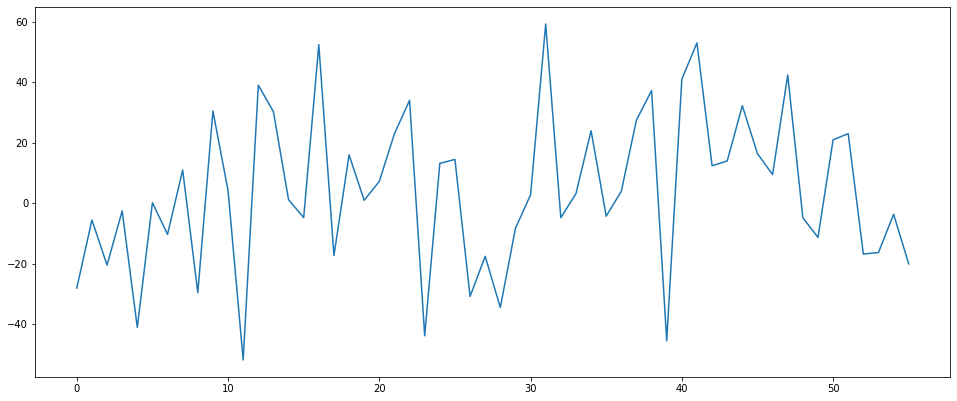

In [8]:

l = len(df[sites])

for s in sites:
    y = df[s][:int(0.8*l)]
    plt.plot(y)
    plt.show()

,CUA,FAC,MER,MON,PED,SAG,TAH,TLA,UIZ,XAL
group,,,,,,,,,,
0,-46.916667,-131.650000,-81.800000,-53.700000,-140.45,-98.983333,-42.383333,-49.65,-65.30,-53.90
1,-134.800000,-81.000000,-88.600000,-41.450000,-170.00,-13.550000,-59.000000,-32.10,-88.35,-43.30
2,-21.700000,-32.300000,-47.250000,-17.850000,-146.30,22.250000,-57.100000,-45.90,-71.85,-28.75
3,-16.900000,-28.500000,43.150000,-0.500000,-23.25,-4.650000,52.600000,-9.00,21.60,-17.05
4,-10.050000,32.700000,-7.900000,66.550000,10.65,37.100000,43.900000,28.75,19.55,70.45
5,18.850000,-42.050000,-25.700000,19.400000,-97.40,5.250000,35.800000,-40.95,-1.90,30.40
6,-62.250000,-82.416667,7.200000,30.166667,-25.75,8.200000,38.200000,-29.75,33.95,24.25
7,-43.850000,-62.200000,-39.350000,6.200000,-75.40,-12.200000,-115.600000,-22.40,-104.65,13.25
8,-105.900000,-115.500000,-36.200000,-32.200000,-44.15,-24.300000,22.250000,-108.50,14.65,-3.05


71

/Users/rodrigo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


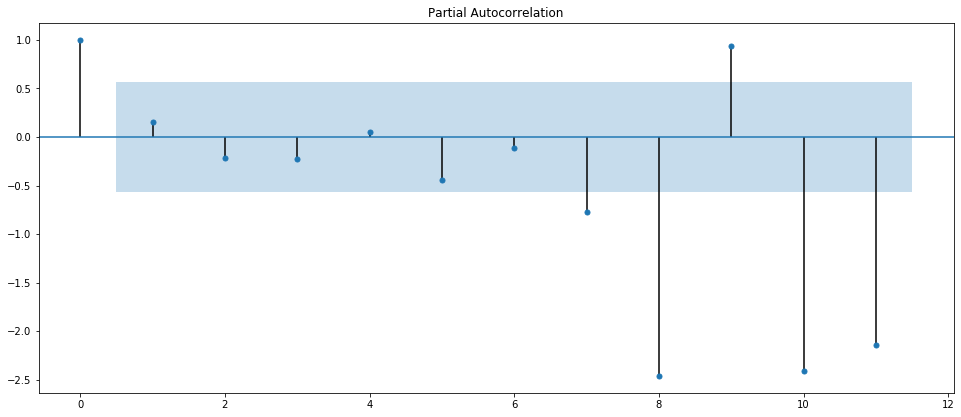

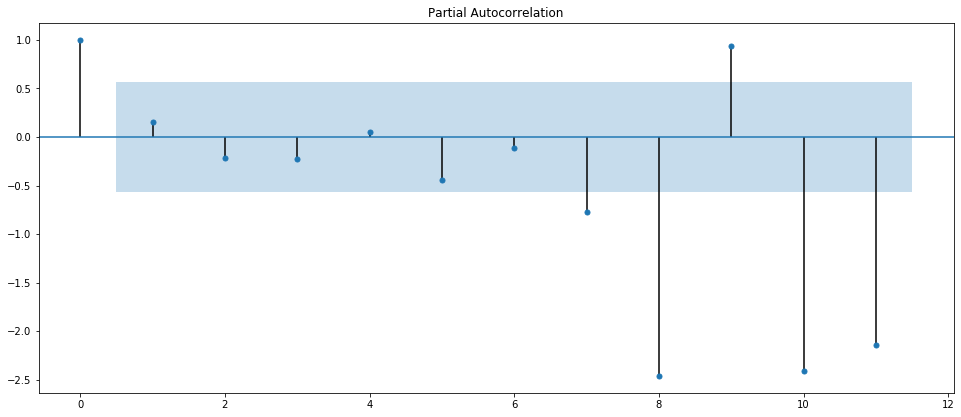

In [119]:
y

group
0     -97.20
1     -45.80
2     100.85
3      37.50
4     -63.20
5      80.25
6     117.35
7     126.95
8      -5.00
9      13.00
10   -163.70
11     16.50
Name: XAL, dtype: float64